In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import (classification_report, confusion_matrix,accuracy_score, recall_score, f1_score,roc_auc_score,
                             accuracy_score,silhouette_score, davies_bouldin_score)
from sklearn.preprocessing import OneHotEncoder,StandardScaler,RobustScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from hdbscan import HDBSCAN
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

In [42]:
gc_df=pd.read_csv('./german_credit_data.csv')
print(gc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None


In [43]:
gc_df.sample(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
381,381,38,female,3,free,little,moderate,12976,18,car,bad
105,105,39,male,3,own,little,moderate,11938,24,vacation/others,bad
291,291,28,male,3,rent,little,moderate,9398,36,car,bad
809,809,26,female,0,rent,little,moderate,1778,15,car,bad
475,475,26,female,2,rent,little,little,3114,18,furniture/equipment,bad
515,515,37,female,2,own,little,little,609,6,car,good
334,334,23,male,2,rent,little,little,4110,24,furniture/equipment,bad
672,672,42,male,3,own,little,NaN,10366,60,car,good
870,870,40,female,2,own,quite rich,NaN,7678,36,furniture/equipment,good
879,879,36,male,2,own,NaN,NaN,6742,30,radio/TV,good


In [44]:
gc_df.isna().sum(),gc_df.duplicated().sum()

(Unnamed: 0            0
 Age                   0
 Sex                   0
 Job                   0
 Housing               0
 Saving accounts     183
 Checking account    394
 Credit amount         0
 Duration              0
 Purpose               0
 Risk                  0
 dtype: int64,
 0)

In [45]:
gc_df.drop(columns=['Unnamed: 0'], inplace=True)

gc_df.fillna({'Checking account': 'no checking account'}, inplace=True)
gc_df.fillna({'Saving accounts': 'no savings account'}, inplace=True)
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
847,28,male,2,own,little,no checking account,1249,24,car,good
858,29,female,2,own,little,little,3959,15,car,bad
371,33,male,2,own,little,no checking account,6070,18,radio/TV,good
81,47,male,2,own,quite rich,no checking account,1213,15,radio/TV,good
981,33,male,3,rent,little,no checking account,4844,48,business,bad
334,23,male,2,rent,little,little,4110,24,furniture/equipment,bad
890,43,male,3,own,little,little,2442,27,business,good
329,28,male,2,own,little,moderate,1068,6,radio/TV,good
518,43,male,2,own,moderate,little,1203,6,car,good
467,32,male,2,own,no savings account,no checking account,7238,48,radio/TV,good


In [46]:
gc_df.Risk.value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [47]:
essential = ['education', 'domestic appliances','repairs']
conditional_Essential=['business','furniture/equipment','car']
nonEssential=['radio/TV','vacation/others']
gc_df['Purpose'] = gc_df['Purpose'].apply(lambda x: 'essential' if x in essential else 'conditional_essential' if x in conditional_Essential else 'nonEssential' if x in nonEssential else x)
gc_df['Purpose'].value_counts()

Purpose
conditional_essential    615
nonEssential             292
essential                 93
Name: count, dtype: int64

In [48]:
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
365,36,male,2,own,little,no checking account,1542,12,conditional_essential,good
845,35,male,2,own,no savings account,moderate,3976,21,conditional_essential,good
346,23,male,2,own,little,moderate,882,13,nonEssential,good
245,25,male,2,own,little,no checking account,1258,24,conditional_essential,good
833,42,female,2,own,no savings account,moderate,5084,24,nonEssential,good
604,23,female,2,own,little,rich,1275,10,conditional_essential,good
258,23,female,2,own,moderate,no checking account,3812,15,conditional_essential,good
317,48,female,1,own,no savings account,moderate,4351,24,conditional_essential,good
707,25,female,2,rent,little,moderate,2969,12,conditional_essential,bad
876,36,male,3,free,little,little,1940,18,nonEssential,good


In [49]:
gc_df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [50]:
gc_df.describe(include='O')

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,1000,1000,1000,1000
unique,2,3,5,4,3,2
top,male,own,little,no checking account,conditional_essential,good
freq,690,713,603,394,615,700


In [51]:
# gc_df['Checking account']=gc_df['Checking account'].map({'no checking account':0,'little':1,'moderate':2,'rich':3})
# gc_df['Saving accounts']=gc_df['Saving accounts'].map({'no savings account':0,'little':1,'moderate':2,'quite rich':3,'rich':4})
# gc_df['Housing']=gc_df['Housing'].map({'own':1,'free':0,'rent':2})
# # gc_df['Purpose']=gc_df['Purpose'].map({'radio/TV':0,'vacation/others':1,'furniture/equipment':2,'business':3,'domestic appliances':4,'repairs':5,'education':6,'car':7})
# gc_df['Purpose']=gc_df['Purpose'].map({'essential':0,'conditional_essential':1,'nonEssential':2})
# gc_df['Sex']=gc_df['Sex'].map({'male':0,'female':1})
gc_df['Risk']=gc_df['Risk'].map({'bad':0,'good':1}).astype(int)


In [52]:
gc_df.isna().sum(),gc_df.duplicated().sum()

(Age                 0
 Sex                 0
 Job                 0
 Housing             0
 Saving accounts     0
 Checking account    0
 Credit amount       0
 Duration            0
 Purpose             0
 Risk                0
 dtype: int64,
 0)

In [53]:
gc_df.shape

(1000, 10)

In [54]:
px.box(gc_df,x='Duration', color='Risk', title='Duration vs Risk', height=400).show()
px.box(gc_df,x='Credit amount', color='Risk', title='Credit amount vs Risk', height=400).show()
px.box(gc_df,x='Age', color='Housing', title='Age vs Housing', height=400).show()

In [55]:
px.histogram(gc_df, x='Age', nbins=30, title='Age Distribution', height=400).show()

In [56]:
px.histogram(gc_df, x='Credit amount', nbins=30, title='Age Distribution', height=400).show()

In [57]:
px.histogram(gc_df, x='Duration', nbins=30, title='Duration Distribution', height=400).show()

In [58]:
gc_df.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
271,37,female,2,rent,quite rich,no checking account,1402,12,conditional_essential,1
446,34,female,2,own,little,little,1842,36,conditional_essential,0
492,27,female,2,own,moderate,no checking account,1237,6,nonEssential,1
349,32,male,2,free,rich,moderate,1136,9,essential,0
690,25,male,2,own,little,little,975,15,conditional_essential,1
612,29,female,2,own,rich,little,3357,21,nonEssential,1
764,27,male,2,own,moderate,no checking account,2463,24,conditional_essential,1
460,37,male,2,own,little,little,3620,36,conditional_essential,1
51,30,male,3,own,little,moderate,5965,27,conditional_essential,1
808,55,male,3,free,little,moderate,9283,42,conditional_essential,1


In [59]:
cat_cols=gc_df.select_dtypes(include='O').columns.to_list()
num_cols=gc_df.select_dtypes(include='number').drop(columns=['Risk']).columns.to_list()

In [60]:
X=gc_df.drop(columns=['Risk'])
y=gc_df['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))
])
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [62]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('scal', num_pipeline,num_cols),
], remainder='passthrough')

In [63]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [64]:
log_pipline=Pipeline([
                     ('preprocessor',preprocessor),
                     ('scaler',RobustScaler()),
                     ('log', LogisticRegression(class_weight='balanced')) 
])
param_grid_log = {'log__C': [0.01, 0.1, 1, 10, 100,1000]}
log_gs = GridSearchCV(log_pipline, param_grid=param_grid_log, cv=cv, scoring='f1')

In [65]:
log_gs.fit(X_train,y_train)
print('Best score:', log_gs.best_estimator_)

Best score: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', '

In [66]:
log=log_gs.best_estimator_
log.fit(X_train,y_train)
y_pred_log=log.predict(X_train)
print(classification_report(y_pred_log,y_train))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60       362
           1       0.68      0.87      0.76       438

    accuracy                           0.70       800
   macro avg       0.72      0.68      0.68       800
weighted avg       0.71      0.70      0.69       800



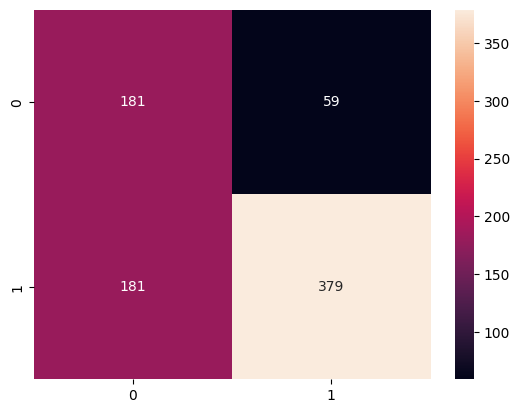

In [67]:
sns.heatmap(confusion_matrix(y_train,y_pred_log),annot=True,fmt='.0f')
plt.show()

In [68]:
rf_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('scaler',RobustScaler()),
    ('rf',RandomForestClassifier(random_state=42,class_weight='balanced'))
])
param_grid_rf= {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__max_depth': [5, 10, 20]
    }
rf_gs=GridSearchCV(rf_pipeline, param_grid=param_grid_rf, cv=cv, scoring='f1')

In [69]:
rf_gs.fit(X_train,y_train)
print('best model:',rf_gs.best_estimator_)

best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', '

In [70]:
rf=rf_gs.best_estimator_
rf.predict(X_train)
y_pred_rf=rf.predict(X_train)
print(classification_report(y_pred_rf,y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



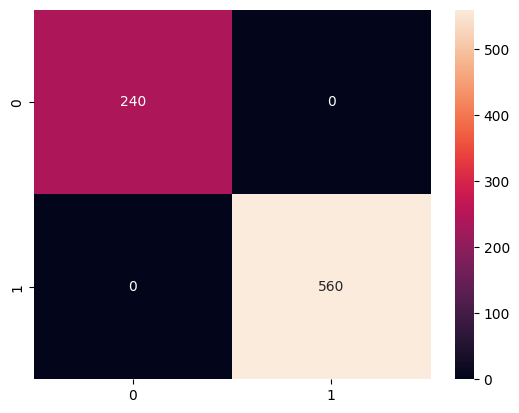

In [71]:
sns.heatmap(confusion_matrix(y_train,y_pred_rf),annot=True,fmt='.0f')
plt.show()

In [72]:
neg, pos = np.bincount(y_train)
scale = neg / pos

In [73]:
xgb_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('scaler',RobustScaler()),
    ('xgb',XGBClassifier(random_state=42,scale_pos_weight=scale))
])
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],'xgb__alpha':[0.01,0.1,1,10,100]
    }
xgb_gs = GridSearchCV(xgb_pipeline, param_grid=param_grid_xgb, cv=cv, scoring='f1')

In [74]:
xgb_gs.fit(X_train,y_train)
print('best model:',xgb_gs.best_estimator_)

best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', '

In [75]:
xgb=xgb_gs.best_estimator_
xgb.fit(X_train,y_train)
xgb.predict(X_train)
y_pred_xgb=xgb.predict(X_train)
print(classification_report(y_pred_xgb,y_train))

              precision    recall  f1-score   support

           0       0.98      0.87      0.93       270
           1       0.94      0.99      0.97       530

    accuracy                           0.95       800
   macro avg       0.96      0.93      0.95       800
weighted avg       0.95      0.95      0.95       800



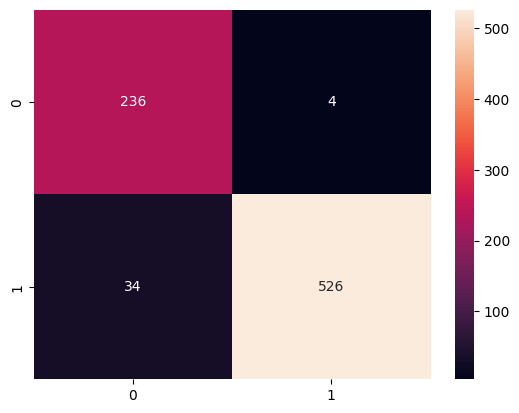

In [76]:
sns.heatmap(confusion_matrix(y_train,y_pred_xgb),annot=True,fmt='.0f')
plt.show()

In [77]:
col=['RandomForestClassifier','XGBoostClassifier','LogisticRegression']
result1=[accuracy_score(y_train,y_pred_rf),accuracy_score(y_train,y_pred_xgb),accuracy_score(y_train,y_pred_log)]
result2=[recall_score(y_train,y_pred_rf),recall_score(y_train,y_pred_xgb),recall_score(y_train,y_pred_log)]
result3=[f1_score(y_train,y_pred_rf),f1_score(y_train,y_pred_xgb),f1_score(y_train,y_pred_log)]
result4=[roc_auc_score(y_train,y_pred_rf),roc_auc_score(y_train,y_pred_xgb),roc_auc_score(y_train,y_pred_log)]
final = pd.DataFrame({'Algorithms':col,'Accuracy':result1,'Recall':result2,'F1':result3,'ROC_AUC':result4})
final

,Algorithms,Accuracy,Recall,F1,ROC_AUC
0,RandomForestClassifier,1.0000,1.000000,1.000000,1.000000
1,XGBoostClassifier,0.9525,0.939286,0.965138,0.961310
2,LogisticRegression,0.7000,0.676786,0.759519,0.715476


In [78]:
final_melted = final.melt(id_vars='Algorithms', value_vars=['Accuracy', 'Recall', 'F1','ROC_AUC'], var_name='Metric', value_name='Score')
fig = px.line(final_melted, x='Algorithms', y='Score', color='Metric', markers=True, title='Model Performance Comparison', labels={'Score': 'Metric Score', 'Algorithms': 'Model'})
fig.show()

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



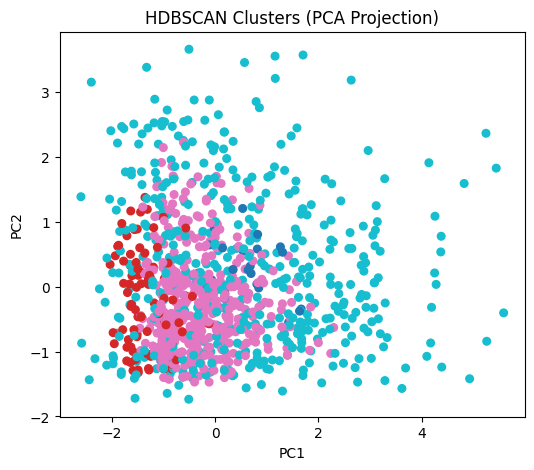

In [84]:
X_num = preprocessor.fit_transform(X)
hdb = HDBSCAN(min_cluster_size=10)
hdb_labels = hdb.fit_predict(X_num)

# Handle noise points (label = -1)
hdb_labels[hdb_labels == -1] = max(hdb_labels) + 1  # Optional: assign noise a unique cluster

# Reduce dimensionality (reuse PCA if desired)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hdb_labels, cmap='tab10', s=30)
plt.title("HDBSCAN Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [85]:
def add_cluster_feature_hdbscan(X):
    clusterer = HDBSCAN(min_cluster_size=10)  # You can tune this
    clusters = clusterer.fit_predict(X)
    # Convert noise (-1) to a valid cluster ID or leave as is
    clusters[clusters == -1] = max(clusters) + 1  # Optional: make noise its own cluster
    return np.column_stack([X, clusters])


cluster_transformer = FunctionTransformer(add_cluster_feature_hdbscan)

In [86]:
pipeline_log_kmeans = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', cluster_transformer), 
    ('scaler', RobustScaler()),
    ('log', LogisticRegression(class_weight='balanced',random_state=42))
])
log_gs_c=GridSearchCV(pipeline_log_kmeans,param_grid=param_grid_log,cv=cv,scoring='f1',n_jobs=-1)

In [87]:
log_gs_c.fit(X_train,y_train)
print('best model: ',log_gs_c.best_estimator_)

best model:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [88]:
log_c=log_gs_c.best_estimator_
log_c.fit(X_train,y_train)
print(classification_report(y_train,log_c.predict(X_train)))

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



              precision    recall  f1-score   support

           0       0.50      0.75      0.60       240
           1       0.87      0.68      0.76       560

    accuracy                           0.70       800
   macro avg       0.68      0.72      0.68       800
weighted avg       0.76      0.70      0.71       800



In [89]:
pipeline_rf_kmeans = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', cluster_transformer), 
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced',random_state=42))
])
rf_gs_c=GridSearchCV(pipeline_rf_kmeans,param_grid=param_grid_rf,cv=cv,scoring='f1')

In [90]:
rf_gs_c.fit(X_train,y_train)
print('best model: ',rf_gs_c.best_estimator_)

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensur

best model:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 

In [91]:
rf_c=rf_gs_c.best_estimator_
rf_c.fit(X_train,y_train)
print(classification_report(y_train,rf_c.predict(X_train)))

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [92]:
pipeline_xgb_kmeans = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', cluster_transformer), 
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier(random_state=42,scale_pos_weight=scale))
])
xgb_gs_c=GridSearchCV(pipeline_xgb_kmeans,param_grid=param_grid_xgb,cv=cv,scoring='f1')

In [93]:
xgb_gs_c.fit(X_train,y_train)
print('best model: ',xgb_gs_c.best_estimator_)

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensur

best model:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose']),
                                                 ('scal',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [94]:
xgb_c=xgb_gs_c.best_estimator_
xgb_c.fit(X_train,y_train)
print(classification_report(y_train,xgb_c.predict(X_train)))

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



              precision    recall  f1-score   support

           0       0.98      1.00      0.99       240
           1       1.00      0.99      1.00       560

    accuracy                           0.99       800
   macro avg       0.99      1.00      0.99       800
weighted avg       0.99      0.99      0.99       800



d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [95]:
col=['RandomForestClassifier','XGBoostClassifier','LogisticRegression']
result1=[accuracy_score(y_train,rf_c.predict(X_train)),accuracy_score(y_train,xgb_c.predict(X_train)),accuracy_score(y_train,log_c.predict(X_train))]
result2=[recall_score(y_train,rf_c.predict(X_train)),recall_score(y_train,xgb_c.predict(X_train)),recall_score(y_train,log_c.predict(X_train))]
result3=[f1_score(y_train,rf_c.predict(X_train)),f1_score(y_train,xgb_c.predict(X_train)),f1_score(y_train,log_c.predict(X_train))]
result4=[roc_auc_score(y_train,rf_c.predict(X_train)),roc_auc_score(y_train,xgb_c.predict(X_train)),roc_auc_score(y_train,log_c.predict(X_train))]
final = pd.DataFrame({'Algorithms':col,'Accuracy':result1,'Recall':result2,'F1':result3,'ROC_AUC':result4})
final

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensur

,Algorithms,Accuracy,Recall,F1,ROC_AUC
0,RandomForestClassifier,1.00000,1.000000,1.000000,1.000000
1,XGBoostClassifier,0.99375,0.991071,0.995516,0.995536
2,LogisticRegression,0.70125,0.678571,0.760761,0.716369


In [96]:
final_melted = final.melt(id_vars='Algorithms', value_vars=['Accuracy', 'Recall', 'F1','ROC_AUC'], var_name='Metric', value_name='Score')
fig = px.line(final_melted, x='Algorithms', y='Score', color='Metric', markers=True, title='Model Performance Comparison', labels={'Score': 'Metric Score', 'Algorithms': 'Model'})
fig.show()

In [97]:
scoring = ['accuracy', 'recall', 'f1', 'roc_auc']

cv_results_log = cross_validate(
    log,  # Use your best estimator pipeline
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

cv_results_log_c = cross_validate(
    log_c,
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)
cv_results_rf = cross_validate(
    rf,  # Use your best estimator pipeline
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)
cv_results_rf_c = cross_validate(
    rf_c,  # Use your best estimator pipeline
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)
cv_results_xgb = cross_validate(
    xgb,  # Use your best estimator pipeline
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)
cv_results_xgb_c = cross_validate(
    xgb_c,  # Use your best estimator pipeline
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\vs-code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensur

In [99]:
cv_results_dict = {
    "LogisticRegression": cv_results_log,
    "LogisticRegression+Cluster": cv_results_log_c,
    "RandomForest": cv_results_rf,
    "RandomForest+Cluster": cv_results_rf_c,
    "XGBoost": cv_results_xgb,
    "XGBoost+Cluster": cv_results_xgb_c
}

for model_name, cv_results in cv_results_dict.items():
    print(f"\nCross-validated metrics for {model_name}:")
    for metric in scoring:
        print(f"{metric}: {cv_results['test_' + metric].mean():.3f} (+/- {cv_results['test_' + metric].std():.3f})")


Cross-validated metrics for LogisticRegression:
accuracy: 0.694 (+/- 0.025)
recall: 0.679 (+/- 0.027)
f1: 0.756 (+/- 0.021)
roc_auc: 0.758 (+/- 0.025)

Cross-validated metrics for LogisticRegression+Cluster:
accuracy: 0.696 (+/- 0.018)
recall: 0.724 (+/- 0.071)
f1: 0.768 (+/- 0.028)
roc_auc: 0.758 (+/- 0.023)

Cross-validated metrics for RandomForest:
accuracy: 0.743 (+/- 0.009)
recall: 0.896 (+/- 0.012)
f1: 0.830 (+/- 0.006)
roc_auc: 0.750 (+/- 0.023)

Cross-validated metrics for RandomForest+Cluster:
accuracy: 0.740 (+/- 0.017)
recall: 0.934 (+/- 0.014)
f1: 0.834 (+/- 0.009)
roc_auc: 0.745 (+/- 0.013)

Cross-validated metrics for XGBoost:
accuracy: 0.713 (+/- 0.043)
recall: 0.767 (+/- 0.058)
f1: 0.788 (+/- 0.037)
roc_auc: 0.749 (+/- 0.027)

Cross-validated metrics for XGBoost+Cluster:
accuracy: 0.717 (+/- 0.025)
recall: 0.809 (+/- 0.052)
f1: 0.799 (+/- 0.022)
roc_auc: 0.730 (+/- 0.036)


In [101]:
import pickle

with open("best_model.pkl", "wb") as f:
    pickle.dump(rf_c, f)
